**Packages**

In [1]:
import re
import numpy as np
from pprint import pprint

import spacy

In [2]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [3]:
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import imp

tools = imp.load_source('tools', '../lda_tools.py')

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import matplotlib as mpl
mpl.rcParams['legend.numpoints'] = 1

%matplotlib inline

In [6]:
font = {"size": 10, "weight": "bold"}
matplotlib.rc("font", **font)

In [7]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

**The data set**

In [8]:
import pandas as pd

In [9]:
df = pd.read_csv('../data/prisoners_dilemma_articles_meta_data_clean.csv')

In [10]:
data = df[['abstract', 'unique_key', 'title', 'date']]

In [11]:
data = data.drop_duplicates()

In [12]:
data = data.reset_index(drop=True)

In [13]:
data.head()

,abstract,unique_key,title,date
0,Starting from the widely accepted Prisoners' D...,15e98165e6239d097ecc05955cc92aa8,Conditions for disarmament: A game theoretical...,1994.0
1,This paper clarifies some basic concepts or as...,e00c31a5f12dcf28f3c11eca5dc786ad,A note on the prisoner's dilemma,1994.0
2,It is argued that without a controversial and...,f2c82cc1f1badea3a092cdffbe63adc5,The indefinitely iterated prisoner's dilemma: ...,1993.0
3,The prisoner’s dilemma game was played by Ss s...,d73da4e47380563abab996c0cf625b64,Cooperation in the prisoner’s dilemma as a fun...,1972.0
4,Agent-based models consist of purposeful agent...,96a525ec0a3901e7435e7939bad07ea0,Agent-Based Models,2018.0


In [14]:
len(data)

2470

In [15]:
data.describe()

,date
count,2469.000000
mean,2009.747266
std,8.978867
min,1951.000000
25%,2007.000000
50%,2012.000000
75%,2015.000000
max,2018.000000


**Sentences to words**

In [16]:
words = list(tools.sentences_to_words(data['abstract'].values))

**Cleaning data set**

In [17]:
from nltk.corpus import stopwords

In [18]:
stop_words = stopwords.words('english')

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [20]:
lemmatized_words = tools.clean_words(words, stop_words)

In [21]:
len(lemmatized_words)

2470

In [22]:
len(words)

2470

**Create corpus**

In [23]:
id2word = corpora.Dictionary(lemmatized_words)

texts = lemmatized_words

corpus = [id2word.doc2bow(text) for text in texts]

**Create model and select number of topics**

In [24]:
mallet_path = '/Users/storm/rsc/mallet-2.0.8/bin/mallet'

In [25]:
limit = 7
start = 5
step = 1

In [26]:
model_list, coherence_values = tools.compute_coherence_values(limit=limit,
                                                              step=step,
                                                              start=start,
                                                              mallet_path=mallet_path,
                                                              dictionary=id2word,
                                                              corpus=corpus,
                                                              texts=lemmatized_words)

In [27]:
# fig = plt.subplots()

# num_of_topics = range(2, limit, 1)
# plt.plot(num_of_topics, coherence_values, '-o', color='black')

# plt.xlabel("number of topics")
# plt.ylabel("Coherence score");

# plt.xticks(num_of_topics)

# plt.savefig("../../assets/images/coherence_values.pdf",
#                 bbox_inches="tight")

In [28]:
num_of_topics = range(start, limit, step)

In [29]:
for num, cv in zip(num_of_topics, coherence_values):
    print("Num Topics =", num, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.4065
Num Topics = 6  has Coherence Value of 0.418


In [30]:
max_coherence_value = max(coherence_values)
max_index = coherence_values.index(max_coherence_value)

In [31]:
num_of_topics[max_index]

6

In [43]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics[max_index], 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [44]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

//anaconda3/envs/literature/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.218099 -0.105817       1        1  44.132702
4     -0.179384  0.091151       2        1  23.967607
2     -0.040406 -0.276994       3        1  14.015332
1     -0.081485  0.273470       4        1   9.868976
5      0.277361 -0.001089       5        1   4.118207
0      0.242012  0.019279       6        1   3.897177, topic_info=     Category         Freq          Term        Total  loglift  logprob
111   Default  1689.000000       network  1689.000000  30.0000  30.0000
21    Default  2887.000000      strategy  2887.000000  29.0000  29.0000
52    Default  2739.000000   cooperation  2739.000000  28.0000  28.0000
845   Default  1408.000000        social  1408.000000  27.0000  27.0000
69    Default  1852.000000        player  1852.000000  26.0000  26.0000
...       ...          ...           ...          ...      ...      ...
1114   Topic6    42.338833   participant   190.252518   1.7423  -5.1744
691    Topic6    41.312897       control   169.331848   1.8342  -5.1989
463    Topic6    31.868456       involve   120.676010   1.9134  -5.4584
135    Topic6    30.772375     associate    97.778923   2.0888  -5.4934
471    Topic6    30.860739  relationship   201.268555   1.3698  -5.4906

[337 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
659       2  0.994949       act
1031      3  0.076205  activity
1031      4  0.914459  activity
896       4  0.986445     actor
727       1  0.993127     adopt
...     ...       ...       ...
3373      6  0.966716   virtual
945       5  0.978169   welfare
1698      6  0.985281     woman
1021      5  0.979311      year
261       5  0.989566       yet

[473 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 2, 6, 1])

In [32]:
num_of_topics[max_index]

6

In [200]:
n_topics = num_of_topics[0]

In [201]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [202]:
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

In [203]:
# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

In [204]:
# T
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2333 samples in 0.001s...
[t-SNE] Computed neighbors for 2333 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2333
[t-SNE] Computed conditional probabilities for sample 2000 / 2333
[t-SNE] Computed conditional probabilities for sample 2333 / 2333
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.169189
[t-SNE] KL divergence after 1000 iterations: 0.709489


In [205]:
 def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [206]:
vor = Voronoi(list(zip(tsne_lda[:,0], tsne_lda[:,1])))

In [207]:
regions, vertices = voronoi_finite_polygons_2d(vor)

In [208]:
colors = np.array([matplotlib.cm.tab20b(3 * i) for i in range(2, 5)] + [matplotlib.cm.tab20c(3 * i) for i in range(1, 4)])

In [209]:
colors_points = np.array([matplotlib.cm.tab20b(i * i) for i in range(2, 5)] + [matplotlib.cm.tab20c(i * i) for i in range(1, 4)])

In [210]:
colors_points[5] = matplotlib.cm.Paired(2)
colors_points[1] = matplotlib.cm.Paired(6)

In [211]:
legend_elements = [Line2D([0], [0], marker='o',
                          color='w',
                          label=f'Topic {i + 1}',
                          markersize=10,
                          markerfacecolor=c) for i, c in enumerate(colors_points[:-1])]

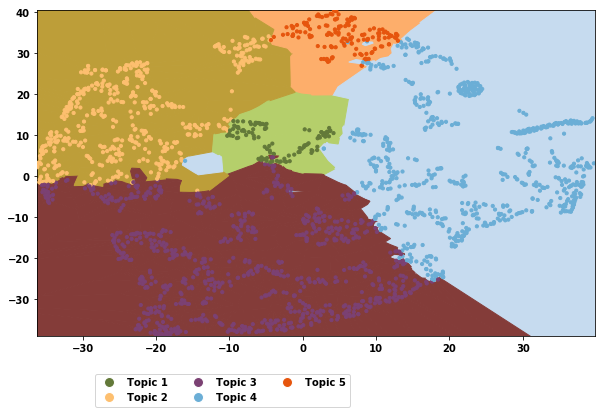

In [219]:
fig, axes = plt.subplots(figsize=(10, 6))

for region, color in zip(regions, colors[topic_num]):
    polygon = vertices[region]
    plt.fill(*zip(*polygon), color=color, edgecolor='none')

plt.scatter(x=tsne_lda[:,0],
            y=tsne_lda[:,1],
            s=10,
            zorder=100,
            color=colors_points[topic_num])

plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

axes.legend(handles=legend_elements,
            bbox_to_anchor=(.57, -0.10),
            ncol=3);

fig.savefig(f"../../assets/images/topics_scatter_plot_{n_topics}.pdf",
                bbox_inches="tight")

In [147]:
n_topics

6

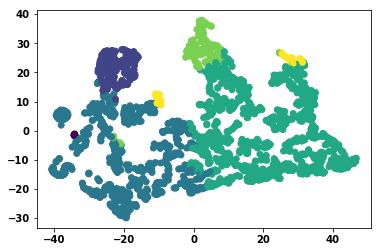

In [72]:
plt.scatter(x=tsne_lda[:,0],
            y=tsne_lda[:,1],
            color=colors[topic_num]);

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import polygonize,unary_union
from shapely.geometry import LineString, MultiPolygon, MultiPoint, Point
from scipy.spatial import Voronoi

In [ ]:

points = [[-30.0, 30.370371], [-27.777777, 35.925926], [-34.444443, 58.51852], [-2.9629631, 57.777779], [-17.777779, 75.185181], [-29.25926, 58.148151], [-11.111112, 33.703705], [-11.481482, 40.0], [-27.037037, 40.0], [-7.7777777, 94.444443], [-2.2222223, 122.22222], [-20.370371, 106.66667], [1.1111112, 125.18518], [-6.2962961, 128.88889], [6.666667, 133.7037], [11.851852, 136.2963], [8.5185184, 140.74074], [20.370371, 92.962959], [17.777779, 114.81482], [12.962962, 97.037041], [13.333334, 127.77778], [22.592592, 120.37037], [16.296295, 127.77778], [11.851852, 50.740742], [20.370371, 54.814816], [19.25926, 47.40741], [32.59259, 122.96296], [20.74074, 130.0], [24.814816, 84.814819], [26.296295, 91.111107], [56.296295, 131.48149], [60.0, 141.85185], [32.222221, 136.66667], [53.703705, 147.03703], [87.40741, 196.2963], [34.074074, 159.62964], [34.444443, -2.5925925], [36.666668, -1.8518518], [34.074074, -7.4074073], [35.555557, -18.888889], [76.666664, -39.629627], [35.185184, -37.777779], [25.185184, 14.074074], [42.962959, 32.962963], [35.925926, 9.2592592], [52.222221, 77.777779], [57.777779, 92.222221], [47.037041, 92.59259], [82.222221, 54.074074], [48.888889, 24.444445], [35.925926, 47.777779], [50.740742, 69.259254], [51.111111, 51.851849], [56.666664, -12.222222], [117.40741, -4.4444447], [59.629631, -5.9259262], [66.666664, 134.07408], [91.481483, 127.40741], [66.666664, 141.48149], [53.703705, 4.0740738], [85.185181, 11.851852], [69.629631, 0.37037039], [68.518517, 99.259262], [75.185181, 100.0], [70.370369, 113.7037], [74.444443, 82.59259], [82.222221, 93.703697], [72.222221, 84.444443], [77.777779, 167.03703], [88.888893, 168.88889], [73.703705, 178.88889], [87.037041, 123.7037], [78.518517, 97.037041], [95.555557, 52.962959], [85.555557, 57.037041], [90.370369, 23.333332], [100.0, 28.51852], [88.888893, 37.037037], [87.037041, -42.962959], [89.259262, -24.814816], [93.333328, 7.4074073], [98.518517, 5.185185], [92.59259, 1.4814816], [85.925919, 153.7037], [95.555557, 154.44444], [92.962959, 150.0], [97.037041, 95.925919], [106.66667, 115.55556], [92.962959, 114.81482], [108.88889, 56.296295], [97.777779, 50.740742], [94.074081, 89.259262], [96.666672, 91.851852], [102.22222, 77.777779], [107.40741, 40.370369], [105.92592, 29.629629], [105.55556, -46.296295], [118.51852, -47.777779], [112.22222, -43.333336], [112.59259, 25.185184], [115.92592, 27.777777], [112.59259, 31.851852], [107.03704, -36.666668], [118.88889, -32.59259], [114.07408, -25.555555], [115.92592, 85.185181], [105.92592, 18.888889], [121.11111, 14.444445], [129.25926, -28.51852], [127.03704, -18.518518], [139.25926, -12.222222], [141.48149, 3.7037036], [137.03703, -4.814815], [153.7037, -26.666668], [-2.2222223, 5.5555558], [0.0, 9.6296301], [10.74074, 20.74074], [2.2222223, 54.074074], [4.0740738, 50.740742], [34.444443, 46.296295], [11.481482, 1.4814816], [24.074076, -2.9629631], [74.814819, 79.259254], [67.777779, 152.22223], [57.037041, 127.03704], [89.259262, 12.222222]]
points = np.array(points)
vor = Voronoi(points)
lines = [
    LineString(vor.vertices[line])
    for line in vor.ridge_vertices if -1 not in line
]

convex_hull = MultiPoint([Point(i) for i in points]).convex_hull.buffer(2)
result = MultiPolygon(
    [poly.intersection(convex_hull) for poly in polygonize(lines)])
result = MultiPolygon(
    [p for p in result]
    + [p for p in convex_hull.difference(unary_union(result))])

plt.plot(points[:,0], points[:,1], 'ko')
for r in result:
    plt.fill(*zip(*np.array(list(
        zip(r.boundary.coords.xy[0][:-1], r.boundary.coords.xy[1][:-1])))),
        alpha=0.4)
plt.show()

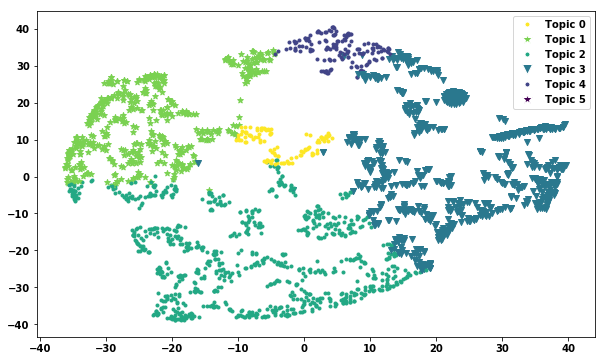

In [55]:
fig, axes = plt.subplots(figsize=(10, 6))


for i, topic in enumerate(topic_num):
    axes.scatter(x=tsne_lda[i,0],
                 y=tsne_lda[i,1],
                 color=colors[topic],
                marker=markers[topic],
               );
axes.legend(handles=legend_elements);

    
fig.savefig(f"../../assets/images/topics_scatter_plot_{n_topics}.pdf",
                bbox_inches="tight")

In [132]:
# legend_elements = [Line2D([0], [0], marker='o',
#                           color='w',
#                           label=f'Topic {i}',
#                           markersize=10,
#                           markerfacecolor=c) for i, c in enumerate(colors)]

# fig, axes = plt.subplots(figsize=(10, 6.5))
# n_topics = 6

# plt.scatter(x=tsne_lda[:,0],
#             y=tsne_lda[:,1],
#             color=colors[topic_num],
#             s=10
#            );

# axes.legend(handles=legend_elements);

# fig.savefig("../../assets/images/topics_scatter_plot.pdf",
#                 bbox_inches="tight")

In [58]:
tsne_lda[:,0]

array([-23.199783, -31.481075,  -7.817138, ..., -36.8525  , -38.80032 ,
       -37.02303 ], dtype=float32)

In [30]:
pprint(model_list[max_index].print_topics())

[(0,
  '0.039*"population" + 0.028*"evolutionary" + 0.026*"dynamic" + 0.021*"model" '
  '+ 0.014*"selection" + 0.013*"result" + 0.011*"evolution" + 0.011*"evolve" + '
  '0.011*"show" + 0.010*"process"'),
 (1,
  '0.105*"game" + 0.084*"strategy" + 0.053*"player" + 0.041*"agent" + '
  '0.021*"play" + 0.018*"dilemma" + 0.016*"state" + 0.014*"prisoner" + '
  '0.014*"payoff" + 0.013*"equilibrium"'),
 (2,
  '0.024*"behavior" + 0.022*"social" + 0.019*"human" + 0.018*"decision" + '
  '0.016*"study" + 0.016*"experiment" + 0.013*"make" + 0.013*"suggest" + '
  '0.011*"result" + 0.011*"behaviour"'),
 (3,
  '0.090*"cooperation" + 0.055*"network" + 0.024*"interaction" + '
  '0.021*"structure" + 0.021*"study" + 0.019*"evolution" + 0.016*"find" + '
  '0.014*"behavior" + 0.014*"cooperative" + 0.014*"simulation"'),
 (4,
  '0.033*"model" + 0.027*"theory" + 0.017*"system" + 0.015*"base" + '
  '0.015*"paper" + 0.014*"problem" + 0.013*"propose" + 0.011*"present" + '
  '0.011*"approach" + 0.011*"provide"'),
 

In [31]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [32]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

//anaconda3/envs/literature/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.175018  0.070964       1        1  48.583702
1      0.130793 -0.215867       2        1  26.112362
2     -0.010565  0.205829       3        1  19.035570
0     -0.295247 -0.060927       4        1   6.268364, topic_info=     Category         Freq         Term        Total  loglift  logprob
52    Default  2765.000000  cooperation  2765.000000  30.0000  30.0000
21    Default  2770.000000     strategy  2770.000000  29.0000  29.0000
845   Default  1454.000000       social  1454.000000  28.0000  28.0000
173   Default  1219.000000   individual  1219.000000  27.0000  27.0000
111   Default  1665.000000      network  1665.000000  26.0000  26.0000
...       ...          ...          ...          ...      ...      ...
2063   Topic4    49.727810        trait   100.442657   2.0666  -5.4888
484    Topic4    57.137138         face   169.534027   1.6821  -5.3499
721    Topic4    52.599655      measure   173.284576   1.5774  -5.4326
243    Topic4    44.822636     increase   504.664642   0.3485  -5.5926
442    Topic4    39.091202        study  1335.874268  -0.7618  -5.7294

[252 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
727       1  0.995717     adopt
2990      2  0.982268  adoption
1939      4  0.979988       age
23        1  0.998856     agent
2945      2  0.989202  alliance
...     ...       ...       ...
1587      3  0.990498      user
3373      3  0.028455   virtual
3373      4  0.967464   virtual
4015      4  0.976692     virus
1698      4  0.983824     woman

[345 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [33]:
pprint(model_list[2].print_topics())

[(0,
  '0.040*"model" + 0.038*"network" + 0.029*"agent" + 0.018*"system" + '
  '0.018*"base" + 0.016*"study" + 0.012*"structure" + 0.010*"dynamic" + '
  '0.009*"simulation" + 0.009*"propose"'),
 (1,
  '0.027*"social" + 0.019*"group" + 0.017*"behavior" + 0.014*"human" + '
  '0.012*"decision" + 0.011*"make" + 0.011*"experiment" + 0.009*"punishment" + '
  '0.008*"study" + 0.008*"suggest"'),
 (2,
  '0.059*"cooperation" + 0.030*"individual" + 0.025*"population" + '
  '0.020*"evolution" + 0.019*"evolutionary" + 0.015*"interaction" + '
  '0.013*"cooperator" + 0.012*"mechanism" + 0.012*"cooperative" + '
  '0.011*"level"'),
 (3,
  '0.075*"game" + 0.060*"strategy" + 0.038*"player" + 0.021*"dilemma" + '
  '0.016*"theory" + 0.016*"play" + 0.012*"payoff" + 0.012*"state" + '
  '0.010*"prisoner" + 0.010*"show"')]


In [34]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [35]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

//anaconda3/envs/literature/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.213708 -0.048510       1        1  44.062511
4      0.156347  0.195412       2        1  26.968443
2      0.048226 -0.248031       3        1  15.761373
1     -0.130466  0.132718       4        1   8.714449
0     -0.287815 -0.031588       5        1   4.493224, topic_info=     Category         Freq         Term        Total  loglift  logprob
52    Default  2706.000000  cooperation  2706.000000  30.0000  30.0000
21    Default  2851.000000     strategy  2851.000000  29.0000  29.0000
845   Default  1426.000000       social  1426.000000  28.0000  28.0000
173   Default  1173.000000   individual  1173.000000  27.0000  27.0000
111   Default  1713.000000      network  1713.000000  26.0000  26.0000
...       ...          ...          ...          ...      ...      ...
1319   Topic5    61.165966       specie    94.470428   2.6679  -4.9488
759    Topic5    30.903009         tell    39.345116   2.8611  -5.6315
434    Topic5    38.701820          low   242.214020   1.2687  -5.4065
3644   Topic5    31.471149      cheater    51.341415   2.6132  -5.6133
484    Topic5    31.223843         face   171.843323   1.3972  -5.6212

[297 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
659       2  0.983864     act
131       1  0.595139  action
131       2  0.132895  action
131       3  0.011556  action
131       4  0.260012  action
...     ...       ...     ...
324       4  0.080834     use
1587      3  0.989500    user
4015      5  0.967945   virus
1698      5  0.970888   woman
870       1  0.992460   world

[407 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 2, 1])

In [37]:
pprint(model_list[3].print_topics())

[(0,
  '0.040*"social" + 0.031*"behavior" + 0.018*"human" + 0.016*"study" + '
  '0.013*"experiment" + 0.012*"cooperative" + 0.011*"cooperation" + '
  '0.010*"suggest" + 0.009*"find" + 0.009*"behaviour"'),
 (1,
  '0.027*"individual" + 0.025*"group" + 0.015*"good" + 0.012*"show" + '
  '0.012*"high" + 0.012*"increase" + 0.011*"punishment" + 0.011*"cost" + '
  '0.011*"result" + 0.009*"benefit"'),
 (2,
  '0.092*"game" + 0.073*"strategy" + 0.047*"player" + 0.036*"agent" + '
  '0.025*"dilemma" + 0.020*"play" + 0.015*"payoff" + 0.015*"state" + '
  '0.012*"prisoner" + 0.012*"equilibrium"'),
 (3,
  '0.061*"cooperation" + 0.043*"network" + 0.030*"population" + '
  '0.026*"evolutionary" + 0.024*"evolution" + 0.022*"interaction" + '
  '0.020*"dynamic" + 0.017*"structure" + 0.016*"cooperator" + 0.015*"study"'),
 (4,
  '0.034*"model" + 0.023*"theory" + 0.019*"base" + 0.016*"system" + '
  '0.012*"problem" + 0.012*"paper" + 0.011*"propose" + 0.011*"information" + '
  '0.010*"provide" + 0.009*"approach"

In [46]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [47]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

//anaconda3/envs/literature/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.181013  0.003826       1        1  45.520134
2      0.187170  0.092989       2        1  34.825104
3     -0.098749 -0.258855       3        1  13.778637
1     -0.269433  0.162040       4        1   5.876124, topic_info=     Category         Freq         Term        Total  loglift  logprob
110   Default  1728.000000      network  1728.000000  30.0000  30.0000
68    Default  2036.000000       player  2036.000000  29.0000  29.0000
144   Default  3660.000000         game  3660.000000  28.0000  28.0000
662   Default   967.000000   population   967.000000  27.0000  27.0000
51    Default  2479.000000  cooperation  2479.000000  26.0000  26.0000
...       ...          ...          ...          ...      ...      ...
473    Topic4    94.433563         rate   249.354630   1.8633  -4.7701
662    Topic4   142.852280   population   967.619934   0.9212  -4.3562
243    Topic4    47.793591     increase   454.301147   0.5824  -5.4512
135    Topic4    39.683910      benefit   242.323715   1.0249  -5.6371
1361   Topic4    37.979973      fitness   128.719086   1.6137  -5.6810

[238 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
698       1  0.996294      able
2223      1  0.024782  abundant
2223      2  0.024782  abundant
2223      4  0.966509  abundant
3845      3  0.984094  accuracy
...     ...       ...       ...
329       1  0.986036   version
329       2  0.011399   version
352       1  0.152328      work
352       2  0.522696      work
352       3  0.322578      work

[294 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

In [48]:
pprint(model_list[2].print_topics())

[(0,
  '0.030*"model" + 0.019*"theory" + 0.014*"system" + 0.010*"problem" + '
  '0.010*"provide" + 0.009*"propose" + 0.009*"base" + 0.009*"information" + '
  '0.008*"approach" + 0.008*"work"'),
 (1,
  '0.059*"cooperation" + 0.036*"network" + 0.023*"population" + '
  '0.021*"evolutionary" + 0.020*"interaction" + 0.020*"evolution" + '
  '0.017*"dynamic" + 0.014*"individual" + 0.013*"cooperator" + '
  '0.012*"structure"'),
 (2,
  '0.076*"game" + 0.060*"strategy" + 0.039*"player" + 0.029*"agent" + '
  '0.018*"dilemma" + 0.016*"play" + 0.012*"payoff" + 0.011*"show" + '
  '0.011*"state" + 0.011*"study"'),
 (3,
  '0.033*"social" + 0.022*"behavior" + 0.020*"group" + 0.017*"individual" + '
  '0.014*"human" + 0.011*"study" + 0.011*"experiment" + 0.010*"result" + '
  '0.009*"cooperative" + 0.009*"suggest"')]


**Choose num = 4**

In [38]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)

In [39]:
def format_topics_sentences(ldamodel,
                            corpus,
                            data_frame):
    data_with_topics = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                data_with_topics = data_with_topics.append(pd.Series([int(topic_num),
                                                                  round(prop_topic,4),
                                                                  topic_keywords]),
                                                         ignore_index=True)
            else:
                break
    data_with_topics.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    data_with_topics = pd.concat([data_with_topics, data_frame], axis=1)
    return data_with_topics

In [40]:
data_with_topics = format_topics_sentences(ldamodel=optimal_model,
                                           corpus=corpus,
                                           data_frame=data)

In [41]:
len(data_with_topics), len(df)

(2470, 19117)

In [42]:
data_with_topics = data_with_topics[["Dominant_Topic", "Perc_Contribution", "Topic_Keywords", 'unique_key']]

In [43]:
len(data_with_topics['unique_key'].unique()), len(df['unique_key'].unique())

(2470, 2470)

In [44]:
merged = df.merge(data_with_topics, on='unique_key')

In [45]:
len(merged), len(merged['unique_key'].unique())

(19117, 2470)

In [46]:
merged.to_csv('../data/prisoners_dilemma_meta_data_with_topics.csv')